## ライブラリー「Darts」を使った時系列分析

In [1]:
%load_ext lab_black

In [2]:
import shutil

import matplotlib.pyplot as plt
import numpy as np
# ライブラリーのインポート
import pandas as pd

%matplotlib inline

import warnings

import torch
import torch.nn as nn
import torch.optim as optim
from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, mase
from darts.models import (ARIMA, FFT, AutoARIMA, ExponentialSmoothing,
                          FourTheta, NaiveDrift, NaiveMean, NaiveSeasonal,
                          NBEATSModel, Prophet, RNNModel, TCNModel, Theta,
                          TransformerModel)
from darts.utils.statistics import (check_seasonality, plot_acf,
                                    plot_residuals_analysis)
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

Importing plotly failed. Interactive plots will not work.


In [3]:
# https://stat.ethz.ch/R-manual/R-devel/library/datasets/html/AirPassengers.html
df = pd.read_csv("../../data/AirPassengers.csv")
# データの中身を確認
df.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [4]:
# DartsのTimeSeriesに変換
series = TimeSeries.from_dataframe(df, time_col="Month", value_cols="#Passengers")

Text(0.5, 0, 'Year')

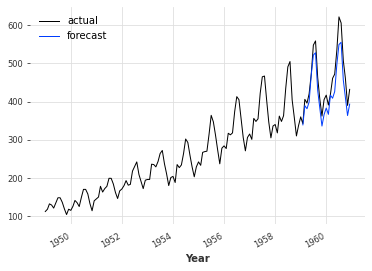

In [5]:
# 1959-01以前と以後に分割
train, val = series.split_after(pd.Timestamp("1959-01"))

# ExponentialSmoothing
# モデル生成
model_es = ExponentialSmoothing()

# 学習
model_es.fit(train)

# 予測 (predictには予測数を入れることに注意)
historical_fcast_es = model_es.predict(len(val))

# 可視化
series.plot(label="actual", lw=1)
historical_fcast_es.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

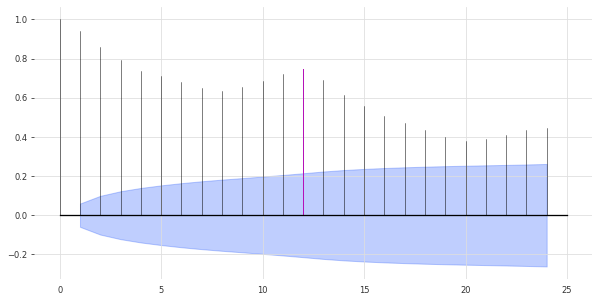

In [6]:
plot_acf(train, m=12, alpha=0.05)

CPU times: user 146 ms, sys: 1.49 ms, total: 147 ms
Wall time: 152 ms


Text(0.5, 0, 'Year')

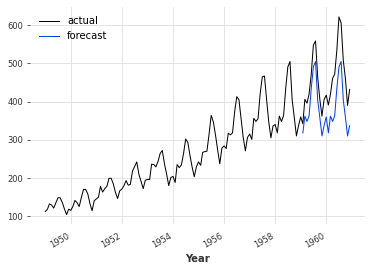

In [7]:
%%time
# NaiveSeasonal
# モデル生成
seasonal_model = NaiveSeasonal(K=12)
# 学習
seasonal_model.fit(train)
# 予測
seasonal_forecast = seasonal_model.predict(len(val))
# 可視化
series.plot(label="actual", lw=1)
seasonal_forecast.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

In [8]:
# %%time
# plot_residuals_analysis(seasonal_model.residuals(series))

CPU times: user 219 ms, sys: 6.61 ms, total: 226 ms
Wall time: 269 ms


Text(0.5, 0, 'Year')

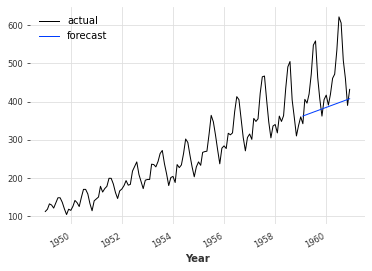

In [9]:
%%time
# NaiveDrift
# モデル生成
drift_model = NaiveDrift()
# 学習
drift_model.fit(train)
# 予測
drift_forecast = drift_model.predict(len(val))

# 可視化
series.plot(label="actual", lw=1)
drift_forecast.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

In [10]:
# %%time
# plot_residuals_analysis(drift_model.residuals(series))

Text(0.5, 0, 'Year')

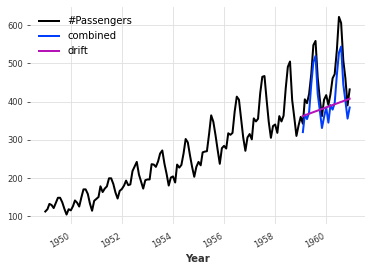

In [11]:
combined_forecast = drift_forecast + seasonal_forecast - train.last_value()

series.plot()
combined_forecast.plot(label="combined")
drift_forecast.plot(label="drift")
plt.legend()
plt.xlabel("Year")

In [12]:
# Search for the best theta parameter, by trying 50 different values
# Theta
thetas = 2 - np.linspace(-10, 10, 50)

best_mape = float("inf")
best_theta = 0

for theta in thetas:
    model = Theta(theta)
    model.fit(train)
    pred_theta = model.predict(len(val))
    res = mape(val, pred_theta)

    if res < best_mape:
        best_mape = res
        best_theta = theta

CPU times: user 195 ms, sys: 0 ns, total: 195 ms
Wall time: 203 ms


Text(0.5, 0, 'Year')

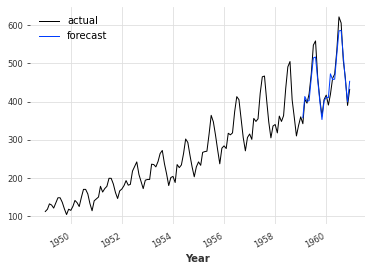

In [13]:
%%time
# Theta
# モデル生成
best_theta_model = Theta(best_theta)
# 学習
best_theta_model.fit(train)
# 予測
pred_best_theta = best_theta_model.predict(len(val))

# 可視化
series.plot(label="actual", lw=1)
pred_best_theta.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

In [14]:
# %%time
# plot_residuals_analysis(best_theta_model.residuals(series))

CPU times: user 519 ms, sys: 0 ns, total: 519 ms
Wall time: 527 ms


Text(0.5, 0, 'Year')

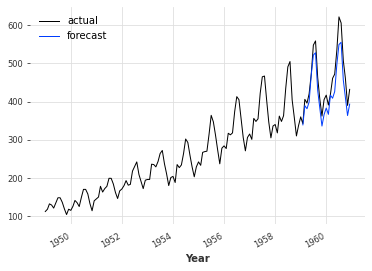

In [15]:
%%time
# ExponentialSmmothing
smoothing_model = ExponentialSmoothing()
smoothing_model.fit(train)
smoothing_prediction = smoothing_model.predict(len(val))

# 可視化
series.plot(label="actual", lw=1)
smoothing_prediction.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

In [16]:
# %%time
# plot_residuals_analysis(smoothing_model.residuals(series))

CPU times: user 3.4 s, sys: 1.7 s, total: 5.1 s
Wall time: 2.7 s


Text(0.5, 0, 'Year')

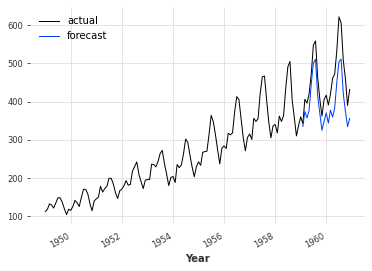

In [17]:
%%time
# ARIMA
arima_model = ARIMA()
arima_model.fit(train)
arima_prediction = arima_model.predict(len(val))

# 可視化
series.plot(label="actual", lw=1)
arima_prediction.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

CPU times: user 15.5 s, sys: 7.88 s, total: 23.4 s
Wall time: 12.7 s


Text(0.5, 0, 'Year')

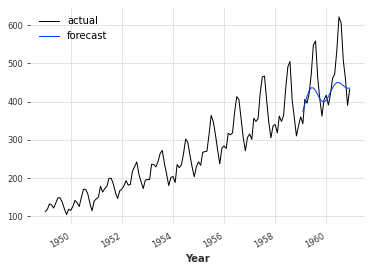

In [18]:
%%time
# AutoARIMA
autoarima_model = AutoARIMA()
autoarima_model.fit(train)
autoarima_prediction = autoarima_model.predict(len(val))

# 可視化
series.plot(label="actual", lw=1)
autoarima_prediction.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

In [19]:
# %%time
# plot_residuals_analysis(autoarima_model.residuals(series))

CPU times: user 11.1 s, sys: 676 ms, total: 11.8 s
Wall time: 14.6 s


Text(0.5, 0, 'Year')

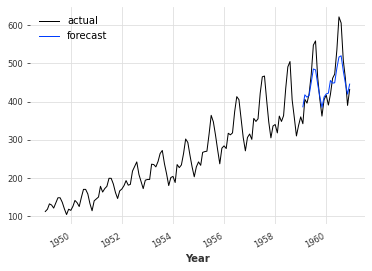

In [20]:
%%time
# Prophet
# モデル生成
prophet_model = Prophet()
# 学習
prophet_model.fit(train)
# 予測
prophet_prediction = prophet_model.predict(len(val))
# 可視化
series.plot(label="actual", lw=1)
prophet_prediction.plot(label="forecast", lw=1)
plt.legend()
plt.xlabel("Year")

In [21]:
# %%time
# plot_residuals_analysis(prophet_model.residuals(series))

In [22]:
%%time
# LSTM

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

LSTM_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=300,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_LSTM",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
)

LSTM_model.fit(train_transformed, val_series=val_transformed, verbose=True)

  0%|          | 0/300 [00:00<?, ?it/s]

CPU times: user 3min 39s, sys: 15.2 s, total: 3min 54sal loss: 0.0128
Wall time: 4min 16s


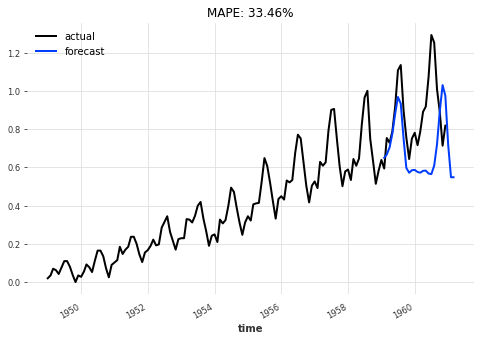

In [23]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8, 5))
    series_transformed.plot(label="actual")
    pred_series.plot(label="forecast")
    plt.title("MAPE: {:.2f}%".format(mape(pred_series, val_transformed)))
    plt.legend()


eval_model(LSTM_model)

loading model_best_250.pth.tar


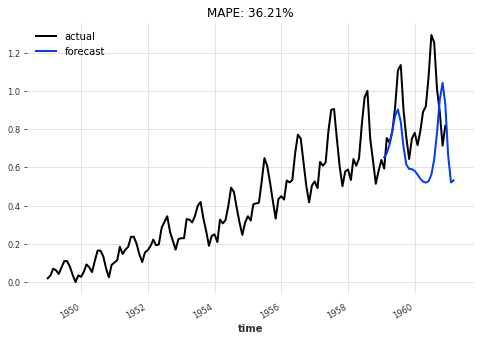

In [24]:
best_model = RNNModel.load_from_checkpoint(model_name="Air_LSTM", best=True)
eval_model(best_model)

In [25]:
%%time
# GRU
gru_model = RNNModel(
    model="GRU",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={"lr": 1e-3},
    model_name="Air_GRU_out12",
    log_tensorboard=True,
    random_state=42,
    training_length=20,
    input_chunk_length=14,
    force_reset=True,
)

gru_model.fit(train_transformed, val_series=val_transformed, verbose=True)

  0%|          | 0/200 [00:00<?, ?it/s]

CPU times: user 2min 57s, sys: 10.9 s, total: 3min 8sval loss: 0.0149
Wall time: 3min 56s


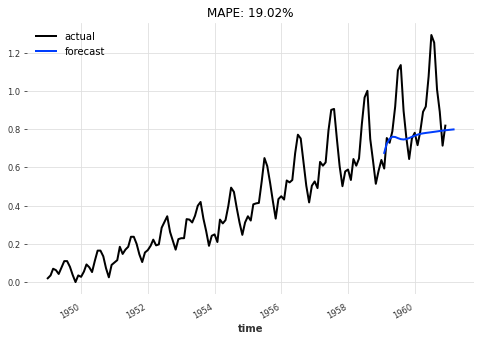

In [26]:
eval_model(gru_model)

loading model_best_190.pth.tar


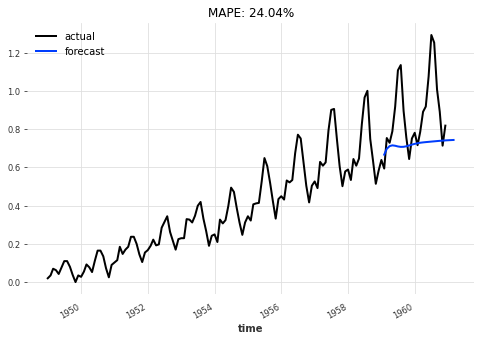

In [27]:
best_model = RNNModel.load_from_checkpoint(model_name="Air_GRU_out12", best=True)
eval_model(best_model)

In [28]:
%%time
# Transformer Model

Transformer_model = TransformerModel(
    input_chunk_length=12,
    output_chunk_length=1,
    batch_size=32,
    n_epochs=400,
    model_name="air_transformer",
    log_tensorboard=True,
    nr_epochs_val_period=10,
    d_model=32,
    nhead=16,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=512,
    dropout=0.1,
    activation="relu",
    random_state=42,
    force_reset=True,
)

Transformer_model.fit(train_transformed, val_series=val_transformed, verbose=True)

  0%|          | 0/400 [00:00<?, ?it/s]

CPU times: user 17min 32s, sys: 6min 2s, total: 23min 34sloss: 0.0043
Wall time: 29min 46s


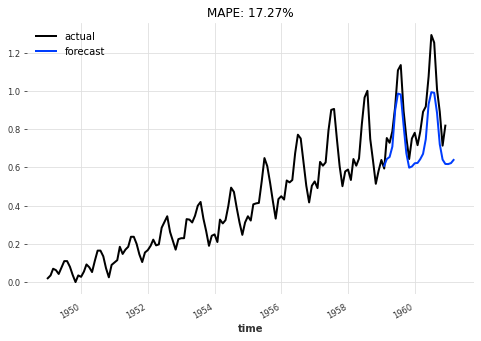

In [29]:
eval_model(Transformer_model)

loading model_best_200.pth.tar


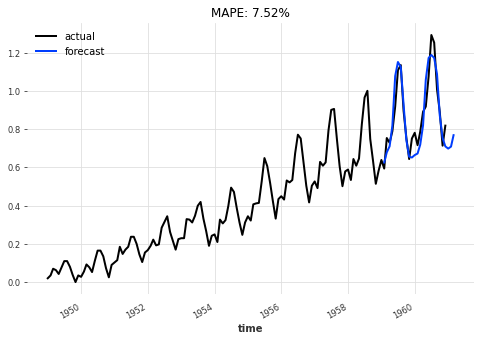

In [30]:
best_model = TransformerModel.load_from_checkpoint(
    model_name="air_transformer", best=True
)
eval_model(best_model)

In [31]:
scaler = Scaler()
ts = scaler.fit_transform(series)
year_series = datetime_attribute_timeseries(ts, attribute="year")
scaler_year = Scaler()
year_series = scaler_year.fit_transform(year_series)

# 1958-08以前と以後に分割
train, val = ts.split_after(pd.Timestamp("1958-08"))
train_year, val_year = year_series.split_after(pd.Timestamp("1958-08"))

In [32]:
%%time
# TCN Model
TCN_model = TCNModel(
    input_chunk_length=13,
    output_chunk_length=12,
    n_epochs=500,
    dropout=0.1,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=3,
    random_state=0,
)

TCN_model.fit(
    series=train,
    past_covariates=train_year,
    val_series=val,
    val_past_covariates=val_year,
    verbose=True,
)

  0%|          | 0/500 [00:00<?, ?it/s]

CPU times: user 2min 34s, sys: 6.56 s, total: 2min 40sal loss: 0.0010
Wall time: 2min 12s


  0%|          | 0/38 [00:00<?, ?it/s]

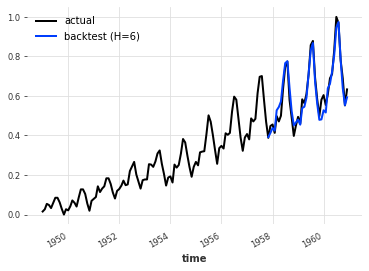

In [35]:
backtest = TCN_model.historical_forecasts(
    series=ts,
    past_covariates=year_series,
    start=0.7,
    forecast_horizon=7,
    stride=1,
    retrain=False,
    verbose=True,
)

ts.plot(label="actual")
backtest.plot(label="backtest (H=6)")
plt.legend()